In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from lib import *
import random

In [27]:
path_train_img = './data/train/'
path_train_mask = './data/train_mask/'
path_test = './data/test/'

## Посмотрим на данные

In [28]:
def plot_images(imgName, path_train_img, path_train_mask):
    img = cv2.imread(path_train_img + '{}.jpg'.format(imgName))
    mask = cv2.imread(path_train_mask + '{}.png'.format(imgName))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(img[...,[2,1,0]])
    axes[1].imshow(mask)
    plt.show()

def plot_image(x,y):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(x)
    axes[1].imshow(np.squeeze(y))
    plt.show()

In [29]:
images = os.listdir(path_train_img)
index = np.random.choice(images).split('.')[0]
mask = cv2.imread(path_train_mask + '{}.png'.format(index))

In [ ]:
img = cv2.imread(path_train_img + '{}.jpg'.format(index))
img.shape, mask.shape

Написать что-нибудь про картинки, сделать наблюдения и т.д.

## Подготовка картинок для нейросети

In [42]:
paths_to_imgs = sorted(glob('data/train/*'))
print('Неправльный путь: ', paths_to_imgs_train[5]) # В windows 10 glob() выдает недействительные пути
paths_to_imgs=[paths_to_imgs[i].replace('\\','/') for i in range(len(paths_to_imgs))]
print('Правильный путь:  ', paths_to_imgs_train[5])

paths_to_masks = sorted(glob('data/train_mask/*'))
paths_to_masks = [paths_to_masks[i].replace('\\','/') for i in range(len(paths_to_masks))]

#Разделим на тренировочную и тестовую выборки
paths_to_imgs_train, paths_to_imgs_test = paths_to_imgs[:900], paths_to_imgs[900:]
paths_to_masks_train, paths_to_masks_test = paths_to_masks[:900], paths_to_masks[900:]

Неправльный путь:  data/train/1001.jpg
Правильный путь:   data/train/1001.jpg


Напишем генератор для подачи изобажений в нейросеть

In [50]:
def generator(paths_to_imgs, paths_to_masks, batch_size):
    while True:
        x_batch = []
        y_batch = []
        paths_to_imgs_tmp = []
        paths_to_masks_tmp = []
        
        #choose random images
        for i in range(batch_size):
            a = random.randint(1,len(paths_to_imgs)-100)
            paths_to_imgs_tmp.append(paths_to_imgs[a])
            paths_to_masks_tmp.append(paths_to_masks[a])
            
        #add images to batch
        for path_to_img, path_to_mask in zip(paths_to_imgs_tmp[:6], paths_to_masks_tmp[:6]):
            img = cv2.resize(cv2.imread(path_to_img), (224,224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.resize(cv2.imread(path_to_mask),(224,224))
            gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            x_batch.append(img)
            y_batch.append(gray_mask)
            
        #add augmented images to batch
        for path_to_img, path_to_mask in zip(paths_to_imgs_tmp[6:], paths_to_masks_tmp[6:]):
            img = cv2.resize(cv2.imread(path_to_img), (224,224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.resize(cv2.imread(path_to_mask),(224,224))
            
            gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            augmented = aug(image=img, mask=gray_mask)
            
            image_medium = augmented['image']
            mask_medium = augmented['mask']
            
            x_batch.append(image_medium)
            y_batch.append(mask_medium)     
       
        #normalize images
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)
        
        yield x_batch, np.expand_dims(y_batch,-1)

In [34]:
for x, y in generator(paths_to_imgs_train, paths_to_masks_train, 16):
    break

In [35]:
y[3].shape

(224, 224, 1)

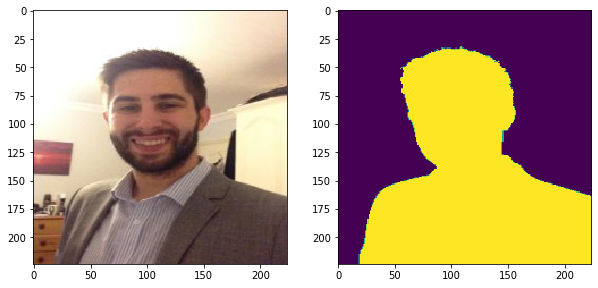

In [36]:
plot_image(x[3],y[3])

In [ ]:
x.shape, y.shape

## Запуск

In [33]:
from albumentations import (
    PadIfNeeded, HorizontalFlip, VerticalFlip, CenterCrop,    
    Crop, Compose, Transpose, RandomRotate90, ElasticTransform,
    GridDistortion, OpticalDistortion, RandomSizedCrop, OneOf, CLAHE,
    RandomBrightnessContrast, RandomGamma)


aug = Compose([    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
          ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
          GridDistortion(p=0.5),
          OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)],
           p=0.8),
    CLAHE(p=0.8),
    RandomBrightnessContrast(p=0.8),    
    RandomGamma(p=0.8)])



In [ ]:
import segmentation_models as sm
from segmentation_models import Unet
from keras.models import load_model

model = sm.Unet('vgg16', encoder_weights='imagenet', activation='sigmoid')
#model.load_weights('./models/model3_weights.h5')
#model=load_model('./models/model3.h5')

LR = 0.001
optim = keras.optimizers.Adam(LR)
model.compile(optim,
    loss=sm.losses.dice_loss,
    metrics=[sm.metrics.f1_score])
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]
results = model.fit_generator(generator(paths_to_imgs_train, paths_to_masks_train, 12),
                             steps_per_epoch=100,
                             epochs=5,
                             callbacks=callbacks,
                             validation_data=generator(paths_to_imgs_test, paths_to_masks_test, 12),
                             validation_steps=50                             
                             )

Epoch 1/5
 41/100 [===========>..................] - ETA: 47s - loss: -0.4730 - f1-score: 1.4730

In [1]:
model.summary()

NameError: name 'model' is not defined

## Посмотим на предсказания модели

In [46]:
def generator_predict(paths_to_imgs, batch_size):
    while True:
        x_batch = []
        paths_to_imgs_tmp=[]
        for i in range(batch_size):
            a=random.randint(1, batch_size)
            paths_to_imgs_tmp.append(paths_to_imgs[a])
        
        for path_to_img in paths_to_imgs_tmp:
            img = cv2.resize(cv2.imread(path_to_img), (256,256))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            x_batch.append(img)
        
        
        x_batch = np.array(x_batch)

        
        yield x_batch

In [47]:
paths_to_imgs_test = sorted(glob('data/test/*'))

for x in generator_predict(paths_to_imgs_test, 80):
    break

In [48]:
pred=model.predict(x)

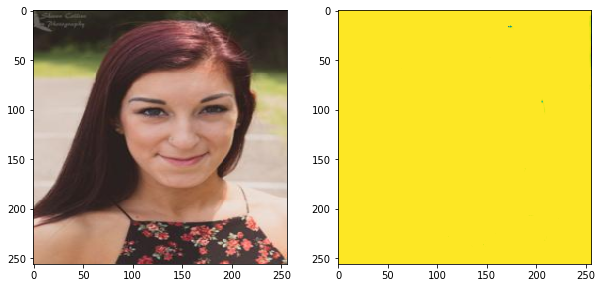

In [49]:
plot_image(x[54], pred[54])

In [ ]:
paths_to_imgs_train = sorted(glob('data/train/*'))

for y in generator_predict(paths_to_imgs_train, 80):
    break
    
pred_test=model.predict(y)

In [ ]:
plot_image(y[54], pred_test[54])

In [1]:
def plot_losses(results):
    
    plt.figure(figsize=(10,10))
    plt.plot(results.history['loss'])
    plt.plot(results.history['iou_score'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


#о метриках
#https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou


In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(10,10))
plt.plot(results.history['loss'])
plt.plot(results.history['iou_score'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


#о метриках
#https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou
